## Customer Churn Project
**December 1st, 2018** <br>
**Austin Jarvis** 

In [1]:
from IPython.display import HTML 
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

### Business Understanding

Customer churn refers to customer turnover or the loss of customers. Telco, a telecommunications company, provides services such as phone and internet to customers. Telco collects data in an attempt to retain customers and prevent churn because customer retrention costs remain far lower than new customer marketing.

This analysis will focus on what factors or interactions lead to churn. Additionally churn can be predicted allowing for companies to focus marketing to certain segments of customers. However, not all churn is predictable 

### Hypothesis

Less than 70% of the churn will be able to be predicted

### Dataset and Exploration

In [2]:
import warnings
warnings.filterwarnings('ignore') 
import pandas.tseries as tseries 
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
import seaborn as sns
import statsmodels.api as sm
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
sns.set_style("darkgrid")
sns.set_context("poster")

rcParams['figure.figsize'] = (12.0, 8.0)

In [3]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
print(df.shape)
print(df.nunique())
#print(df.dtypes)

(7043, 21)
customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64


In [5]:
df['TotalCharges'] = df["TotalCharges"].replace(" ",np.nan)
df = df[df["TotalCharges"].notnull()]
df = df.reset_index()[df.columns]
df["TotalCharges"] = df["TotalCharges"].astype(float)
print(df.dtypes)

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object


In [6]:
def tenure_categories(df) :
    
    if df["tenure"] <= 12 :
        return "Less than 1 year"
    elif (df["tenure"] > 12) & (df["tenure"] <= 24 ):
        return "1-2 years"
    elif (df["tenure"] > 24) & (df["tenure"] <= 48) :
        return "2-3 years"
    elif (df["tenure"] > 48) & (df["tenure"] <= 60) :
        return "3-4 years"
    elif df["tenure"] > 60 :
        return "More than 5 years"
df["tenure_categories"] = df.apply(lambda df:tenure_categories(df),axis = 1)
#df.head()

In [7]:

ChurnData = go.Pie(labels = df["Churn"].value_counts().keys().tolist() ,
               values = df["Churn"].value_counts().values.tolist() ,
               marker = dict(colors =  [ '#5ab4ac' ,'#d8b365'],
                             line = dict(color = "white",width =  2)),
               hoverinfo = "label+value",
               hole = .5,title = "Customer Churn %"
              )
data = [ChurnData]
fig = go.Figure(data = data)
py.iplot(fig)



Almost 3/4 of customers have not churned.

In [8]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
churn = df[df["Churn"] == "Yes"]
not_churn = df[df["Churn"] == "No"]
#churn.head()
Id = ['customerID']
target = ["Churn"]
cat_cols   = df.nunique()[df.nunique() < 6].keys().tolist()
cat_cols   = [x for x in cat_cols if x not in target]
num_cols   = [x for x in df.columns if x not in cat_cols + target + Id]
bin_cols   = df.nunique()[df.nunique() == 2].keys().tolist()
multi_cols = [i for i in cat_cols if i not in bin_cols]
num_cols

le = LabelEncoder()
for i in bin_cols :
    df[i] = le.fit_transform(df[i])
df = pd.get_dummies(data = df,columns = multi_cols )

std = StandardScaler()
scaled = std.fit_transform(df[num_cols])
scaled = pd.DataFrame(scaled,columns=num_cols)



In [9]:
chDF  =  churn["tenure_categories"].value_counts().reset_index()
chDF.columns  = ["tenure_categories","count"]
nchDF =  not_churn["tenure_categories"].value_counts().reset_index()
nchDF.columns = ["tenure_categories","count"]

trace1 = go.Bar(x = chDF["tenure_categories"]  , y = chDF["count"],
                name = "Churn Customers",
                marker = dict(color= "#d8b365",line = dict(width = 1,color = "black")))

trace2 = go.Bar(x = nchDF["tenure_categories"] , y = nchDF["count"],
                name = "Non Churn Customers",
                marker = dict(color= "#5ab4ac",line = dict(width = 1,color = "black")))

layout = go.Layout(dict(title = "Customer Churn Decreases for Long Time Customers",
                        xaxis = dict(title = "Years of Service"),
                        yaxis = dict(title = "count")))
data = [trace1,trace2]
fig  = go.Figure(data=data,layout=layout)
py.iplot(fig)

Length of service plays a significant role in customers churning. Customers who stay past 1 year are much more likely to continue with the service.

In [10]:

correlation = df.corr()

#print(correlation)
matrix_cols = correlation.columns.tolist()

corr_array  = np.array(correlation)

trace = go.Heatmap(z = corr_array,x = matrix_cols,y = matrix_cols,
                   colorscale = "Portland",
                   colorbar   = dict(title = "Pearson Correlation coefficient",
                                     titleside = "right"
                                    ) ,
                  )

layout = go.Layout(dict(title = "Correlation Matrix for variables",height  = 800,
                        width   = 800,margin  = dict(r = 0 ,l = 250, t = 50,b = 250),
                        yaxis   = dict(tickfont = dict(size = 9)),
                        xaxis   = dict(tickfont = dict(size = 8))))

data = [trace]
fig = go.Figure(data=data,layout=layout)
py.iplot(fig)

### Model Building

The following models are designed to predict whether a customer will churn or not. The accuracy shows the how often the model correctly predicted the churn.

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import roc_auc_score,roc_curve,scorer
from sklearn.metrics import f1_score
import statsmodels.api as sm
from sklearn.metrics import precision_score,recall_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

train,test = train_test_split(df,test_size = .25 ,random_state = 111)

cols    = [i for i in df.columns if i not in Id + target]
train_X = train[cols]
train_Y = train[target]
test_X  = test[cols]
test_Y  = test[target]
      


The Logistic Regression Accuracy is: 0.801


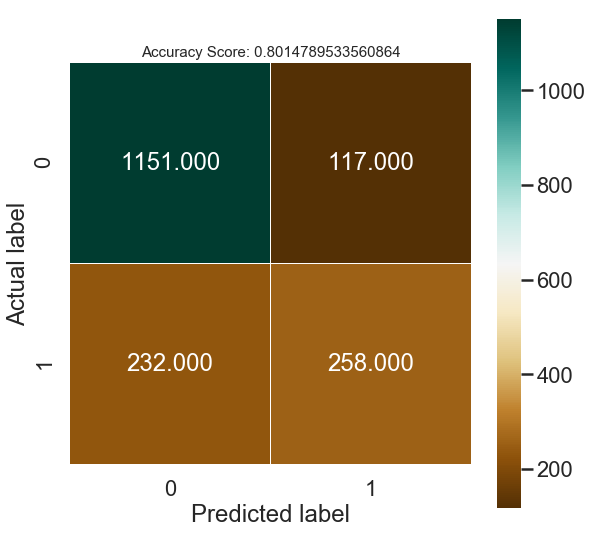

In [12]:
# Logistic Regression
logit  = LogisticRegression()
logit.fit(train_X,train_Y)

predictions = logit.predict(test_X)
score = logit.score(test_X, test_Y)
print('The Logistic Regression Accuracy is:', round(score,3))

cm = metrics.confusion_matrix(test_Y, predictions)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'BrBG');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

The KNN Accuracy is: 0.749


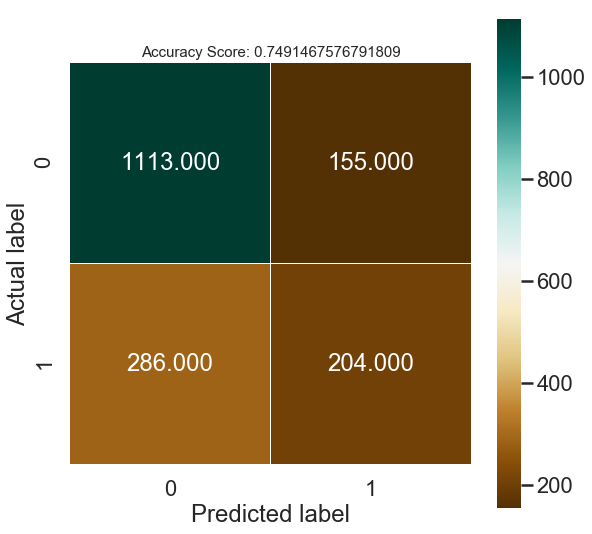

In [13]:
#KNN
from sklearn.neighbors import KNeighborsClassifier
logit = KNeighborsClassifier()
logit.fit(train_X,train_Y)
predictions = logit.predict(test_X)
score = logit.score(test_X, test_Y)
print('The KNN Accuracy is:',round(score,3))
cm = metrics.confusion_matrix(test_Y, predictions)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'BrBG');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);


The Naive Bayes Accuracy is: 0.718


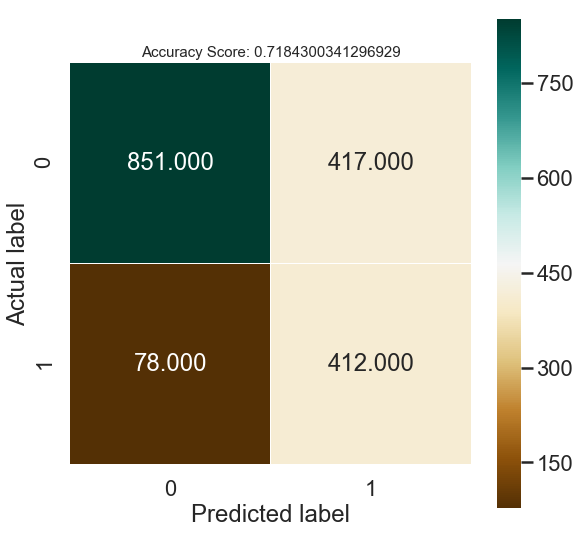

In [14]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB
logit = GaussianNB()
logit.fit(train_X,train_Y)

predictions = logit.predict(test_X)
score = logit.score(test_X, test_Y)
print('The Naive Bayes Accuracy is:',round(score,3))

cm = metrics.confusion_matrix(test_Y, predictions)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'BrBG');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

The logistic regression model outperformed both the K-nearest Neighbor and Naive Bayes Algorithms. The logistic model resulted in an 80% accuracy and therefore we reject the null hypothesis that no model could predict 70% customer churn. This hypothesis was made on the belief that often customers switch services for reasons that are unable to be tracked, such as moving. However this analysis proved customer churn can be predicted quite well, Telcom could use this analysis to reduce the customer churn. An important factor to consider is the years of service as it is seen that if the customer can be obtained past 1 year the churn rate drastically decreases.

Going forward this analysis could be expanded on by optimizing the models further and trying other techniques such as random forest to achieve better prediction accuracy.